In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases  #Package for database reading.
!pip install mne #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!dir

#Import

In [ ]:
from google.colab.drive import mount
import numpy as np
from pickle import load as pload
from MI_EEG_ClassMeth.utils import custom_indexing_list, min_max_normalization
from scipy.stats import zscore
from gcpds.databases.BCI_Competition_IV import Dataset_2a
from mne.channels import make_standard_montage
from mne import create_info
import os
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from scipy.stats import gaussian_kde
from scipy.spatial.distance import squareform
from mne.channels.layout import _find_topomap_coords
from joblib import load as jload
from math import floor, ceil
from MI_EEG_ClassMeth.FeatExtraction import Power_based_Connectivities
import matplotlib as mlp
import pandas as pd
from pickle import dump as pdump

#Mount Drive

In [ ]:
mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Functions

In [ ]:
def ica_channels_contribution(subjects, ica_results_dir, noise=True):
    W_ = []
    for sbj in subjects:
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        W = results_ica['W_unmixing']
        idx_noise_trials = results_ica['idx_noise_trials']
        if noise:
            W_ = W_ + custom_indexing_list(W, idx_noise_trials)
        else:
            idx_trials = np.setdiff1d(np.arange(len(W)), idx_noise_trials, assume_unique=True)
            W_ = W_ + custom_indexing_list(W, idx_trials)

    W_ = np.abs(np.concatenate(W_, axis=0))
    W_ = min_max_normalization(W_)
    median = np.median(W_, axis=0)
    q25, q75 = np.percentile(W_, [25, 75], axis=0)
    return median, q25, q75

In [ ]:
def ica_rho(subjects, ica_results_dir):
    z_rho = []
    for sbj in subjects:
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        rho = results_ica['rho']
        z_rho.append(zscore(rho, axis=1))

    z_rho = np.concatenate(z_rho, axis=0)
    return z_rho

In [ ]:
def ica_noise_trials_ratio(subjects, ica_results_dir):
    noise_trials_ratio = np.zeros(subjects.shape[0])
    for i, sbj in enumerate(subjects):
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        noise_trials_ratio[i] = 100*results_ica['idx_noise_trials'].shape[0]/results_ica['rho'].shape[0]
    return noise_trials_ratio

In [ ]:
def plot_cum_C_xx(C_xx, ch_names, axs, cmap='summer', fontsize=12):
  n_chs = len(ch_names)
  C_xx_norm = min_max_normalization(C_xx, axis=1)

  for ch in range(n_chs):
    C_xx_norm[ch,ch] = 1

  axs.imshow(C_xx_norm, cmap=cmap)
  axs.set_yticks(np.arange(n_chs))
  axs.set_yticklabels(ch_names, fontsize=fontsize)
  axs.set_xticks(np.arange(n_chs))
  axs.set_xticklabels(ch_names, rotation=90, fontsize=fontsize)
  return axs

In [ ]:
def read_CV_results(subjects, cross_val_results_dir, metric):
  results = []
  for sbj in subjects:
    with open(cross_val_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
        cv_results = pload(f)
    results.append(cv_results[metric])
  return np.asarray(results)

In [ ]:
def read_CV_test_results(evaluation_results_dir='', cross_val_results_dir=''):
  test_results = np.load(evaluation_results_dir)
  results = np.zeros((test_results.shape[1], test_results.shape[0]))
  for sbj in range(test_results.shape[1]):
    with open(cross_val_results_dir + '/' + 'sbj' + str(sbj+1) + '.txt', 'rb') as f:
        cv_results = pload(f)
    idx = np.argmax(np.asarray(cv_results['mean_test_acc']))
    results[sbj,:] = test_results[:, sbj, idx]
  return results

In [ ]:
def read_CV_models(subjects, models_dir, best_params):
  models = []
  for sbj, idx_best_params in zip(subjects, best_params):
    clf = jload(models_dir + idx_best_params + '/' + 'sbj' + str(sbj) + '.joblib')
    models.append(clf.coef_)
  return np.asarray(models)

#Results

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preprocessing/results/Thesis/')

Global variables to carry out results analysis.

In [ ]:
results_dir = '/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preprocessing/results/'
mode = 'evaluation'

db = Dataset_2a()
fs = db.metadata['sampling_rate']
subjects = np.arange(db.metadata['subjects']) + 1
eeg_ch_names = db.metadata['channels'][:-3]
n_eeg_chs = len(eeg_ch_names)
eog_ch_names = db.metadata['channels'][-3:]
montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage)

seed = 23

pbc = Power_based_Connectivities()
type_con  = 'gfc' #Connectivity to carry out analysis of results

##ICA

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preproessing/results/ica/training/images/')
os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preproessing/results/ica/evaluation/images/')

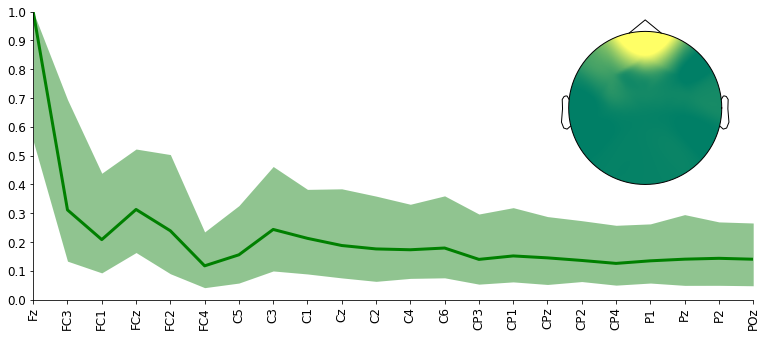

In [ ]:
fig = plt.figure(figsize=(10,4))

median, q25, q75 = ica_channels_contribution(subjects, results_dir + 'ica/' + mode + '/', noise=True)
axs1 = fig.add_axes([0, 0, 1, 1])
axs1.fill_between(np.arange(n_eeg_chs), q25, q75, alpha=.5, color='forestgreen', linewidth=0)
axs1.plot(median,  color='green', linewidth=3)
axs1.spines['right'].set_visible(False)
axs1.spines['top'].set_visible(False)
axs1.set_ylim([0,1])
axs1.set_xlim([0 ,n_eeg_chs-1])
axs1.set_yticks(np.linspace(0,1,11))
axs1.set_yticklabels(np.round(np.linspace(0,1,11), 1), fontsize=12)
axs1.set_xticks(np.arange(n_eeg_chs))
axs1.set_xticklabels(eeg_ch_names, fontsize=12, rotation=90)
#axs1.set_ylabel('Normalized Channels-Noise Ratio', fontfamily='serif', fontsize=22, weight=500)
#axs1.set_xlabel('Channels', fontfamily='serif', fontsize=22, weight=500)

axs2 = fig.add_axes([0.55, 0.4, 0.6, 0.6])
im, _ = plot_topomap(min_max_normalization(median), pos=info, vmin=0, vmax=1, cmap='summer', axes=axs2, contours=0, sensors=False, show=False)
plt.savefig(results_dir + 'ica/' + mode + '/images/' + 'normalized_channels_noise_ratio.pdf', format='pdf', bbox_inches='tight')

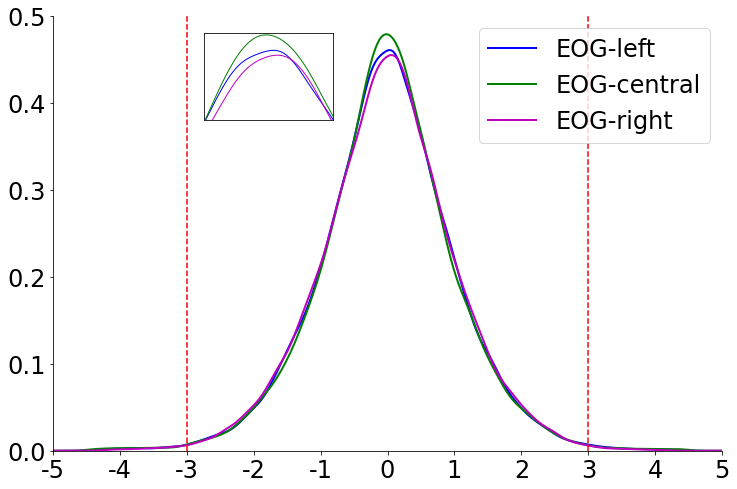

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
aux_axs = fig.add_axes([0.3,0.7,0.15,0.15])

z_rho = ica_rho(subjects, results_dir + 'ica/' + mode + '/')
xmin = int(z_rho.min()) 
xmax = int(z_rho.max())
xmin = xmin if xmin <= -3 else -3
xmax = xmax if xmax >= 3 else 3
xmin -=1
xmax +=1

colors = ['b', 'g', 'm']

max_p = -np.inf
for i in range(z_rho.shape[-1]):
  z_rho_art = z_rho[:,:,i].ravel()
  kde = gaussian_kde(z_rho_art)
  x = np.linspace(xmin, xmax, 300)
  x_peak = np.linspace(-0.5, 0.5, 100)
  pdx = kde.pdf(x)
  max_p = max_p if max_p > pdx.max() else pdx.max()
  axs.plot(x, pdx, linewidth=2, color=colors[i], label=eog_ch_names[i])
  aux_axs.plot(x_peak, kde.pdf(x_peak), linewidth=1, color=colors[i])

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.axvline(3, clip_on = False, color='r', linestyle='dashed')
axs.axvline(-3, clip_on = False, color='r', linestyle='dashed')
axs.set_ylim([0, max_p+0.01])
axs.set_xlim([xmin, xmax])
axs.set_yticks(np.linspace(0, round(max_p, 1), 6))
axs.set_yticklabels(np.round(np.linspace(0, round(max_p, 1), 6), 1), fontsize=24)
axs.set_xticks(np.arange(xmin, xmax+1))
axs.set_xticklabels(np.arange(xmin, xmax+1), fontsize=24)
#axs.set_ylabel(r'$f(\cdot)$', fontfamily='serif', fontsize=22, weight=500)
#axs.set_xlabel(r'$Z_{\rho (s,a)}$', fontfamily='serif', fontsize=22, weight=500)
axs.legend(loc='upper right', fontsize=25)

aux_axs.axes.xaxis.set_visible(False)
aux_axs.axes.yaxis.set_visible(False)
aux_axs.set_ylim([max_p-0.1, max_p+0.002])
aux_axs.set_xlim([-0.45, 0.45])

plt.savefig(results_dir + 'ica/' + mode + '/images/' + 'pdf_rho_s_a.pdf',format='pdf', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


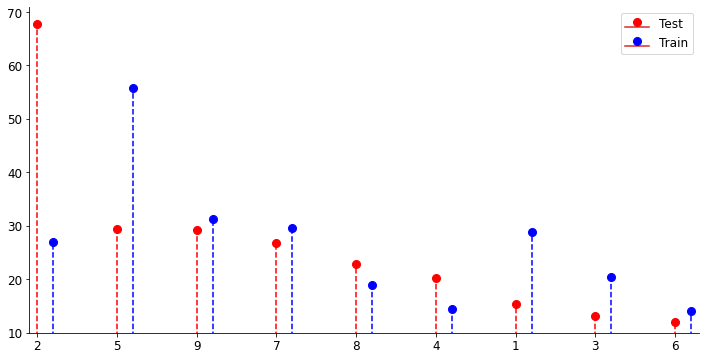

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
noise_trials_ratio_train = ica_noise_trials_ratio(subjects, results_dir + 'ica/training/')
noise_trials_ratio_eval = ica_noise_trials_ratio(subjects, results_dir + 'ica/evaluation/')

idx_ord_noise_trials_ratio = np.argsort(noise_trials_ratio_eval)[::-1]

markerline, stemline, baseline, = axs.stem(np.arange(subjects.shape[0]), noise_trials_ratio_eval[idx_ord_noise_trials_ratio], linefmt='r--', markerfmt='ro', label='Test')
plt.setp(markerline, markersize = 8)

markerline, stemline, baseline, = axs.stem(np.arange(subjects.shape[0])+0.2, noise_trials_ratio_train[idx_ord_noise_trials_ratio], linefmt='b--', markerfmt='bo', label='Train')
plt.setp(markerline, markersize = 8)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_ylim([10*floor(min(noise_trials_ratio_train.min(), noise_trials_ratio_eval.min())/10), 10*ceil(max(noise_trials_ratio_train.max(), noise_trials_ratio_eval.max())/10)+1])
axs.set_xlim([-0.1, subjects.shape[0]-0.7])
axs.set_yticks(np.linspace(10*floor(min(noise_trials_ratio_train.min(), noise_trials_ratio_eval.min())/10), 10*ceil(max(noise_trials_ratio_train.max(), noise_trials_ratio_eval.max())/10), 7, dtype=np.uint16))
axs.set_yticklabels(np.linspace(10*floor(min(noise_trials_ratio_train.min(), noise_trials_ratio_eval.min())/10), 10*ceil(max(noise_trials_ratio_train.max(), noise_trials_ratio_eval.max())/10), 7, dtype=np.uint16), fontsize=12)
axs.set_xticks(np.arange(subjects.shape[0]))
axs.set_xticklabels(subjects[idx_ord_noise_trials_ratio], fontsize=12)
#axs.set_ylabel('(%) Noise trials', fontfamily='serif', fontsize=22, weight=500)
#axs.set_xlabel('Subjects', fontfamily='serif', fontsize=22, weight=500)
plt.legend(loc=1, fontsize=12)
plt.savefig(results_dir + 'ica/' + mode + '/images/' + 'porcentage_noise_trials.pdf',format='pdf', bbox_inches='tight')

## Laplacian Filter

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preproessing/results/sl/training/')
os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preproessing/results/sl/evaluation/')

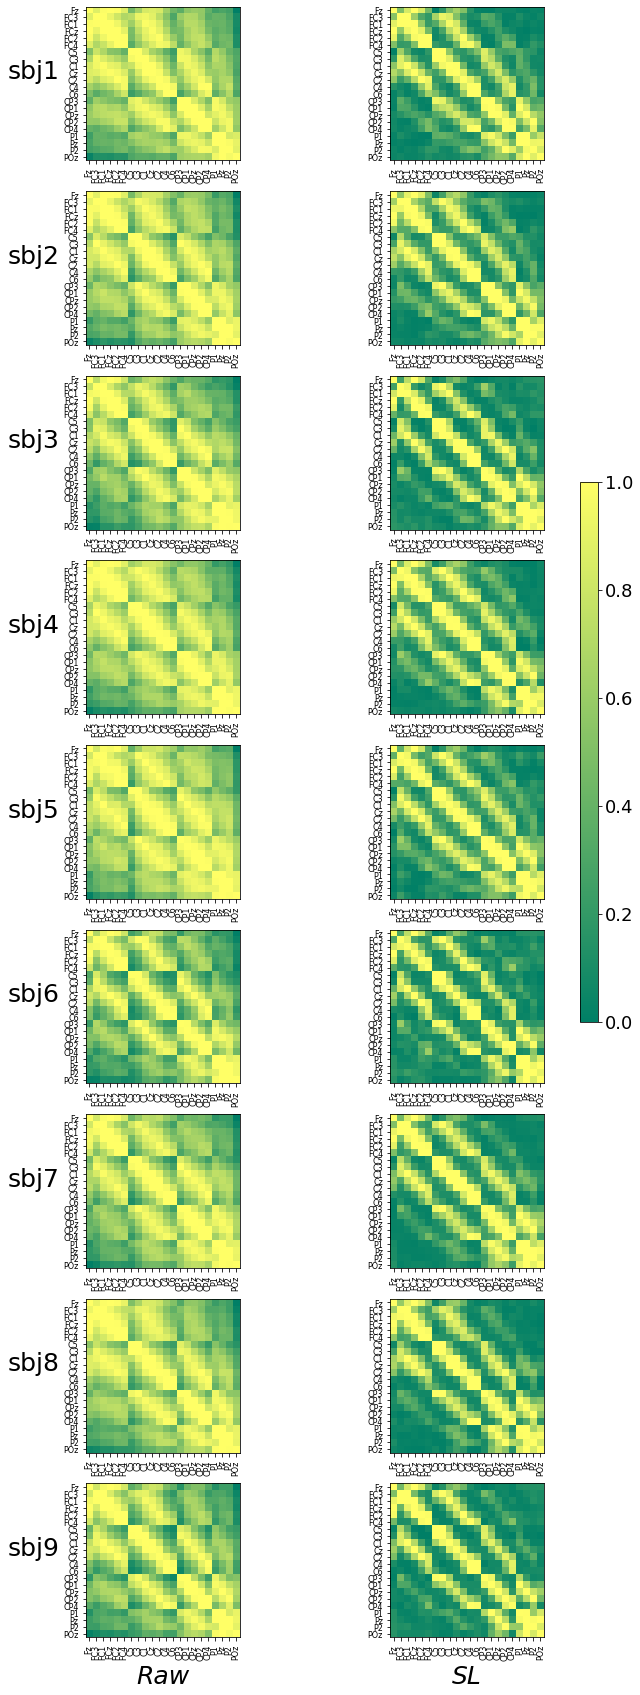

In [ ]:
data_dir = '/content/drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a_preprocessing/data/'

fig, axs = plt.subplots(nrows=db.metadata['subjects'], ncols=2, figsize=(10,30))
cmap = 'summer'
fontsize = 8

C_xx_raw_sbjs = np.zeros(int(n_eeg_chs*(n_eeg_chs-1)*0.5))
C_xx_ica_sl_sbjs = np.zeros(int(n_eeg_chs*(n_eeg_chs-1)*0.5))
# ------------------------------------------------------------------------------

for sbj in subjects:
  X_raw = np.load(data_dir + 'none_none/' + mode + '/sbj'  + str(sbj) + '.npy')
  X_ica_sl = np.load(data_dir + 'ica_sl/' + mode + '/sbj'  + str(sbj) + '.npy')
  C_xx_raw = np.sum(pbc.transform(X_raw, type_con='pearson'), axis=(0,2,3))
  C_xx_ica_sl = np.sum(pbc.transform(X_ica_sl, type_con='pearson'), axis=(0,2,3))
  C_xx_raw_sbjs = C_xx_raw_sbjs + C_xx_raw
  C_xx_ica_sl_sbjs = C_xx_ica_sl_sbjs + C_xx_ica_sl 
  plot_cum_C_xx(squareform(C_xx_raw).copy(), eeg_ch_names, axs[sbj-1,0], cmap=cmap, fontsize=fontsize )
  axs[sbj-1,0].set_ylabel('sbj'+str(sbj), fontsize=25, weight=500, rotation=0, ha='right')
  plot_cum_C_xx(squareform(C_xx_ica_sl).copy(), eeg_ch_names, axs[sbj-1,1], cmap=cmap, fontsize=fontsize )

C_xx_raw_sbjs = squareform(C_xx_raw_sbjs)
C_xx_ica_sl_sbjs = squareform(C_xx_ica_sl_sbjs)

del C_xx_raw
del C_xx_ica_sl

axs[-1,0].set_xlabel('Raw', fontstyle='italic', ha='center', fontsize=25, weight=500)
axs[-1,1].set_xlabel('SL', fontstyle='italic', ha='center', fontsize=25, weight=500)
cax = fig.add_axes([axs[-1,-1].get_position().x1 + 0.05, 0.41, 0.025, 0.25])
norm = mlp.colors.Normalize(vmin=0, vmax=1) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([]) 
cbar = fig.colorbar(sm, cax=cax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(18)
plt.savefig(results_dir + 'sl/' + mode  + '/raw_vs_ica_sl_sbjs_C_xx.pdf', format='pdf', bbox_inches='tight')

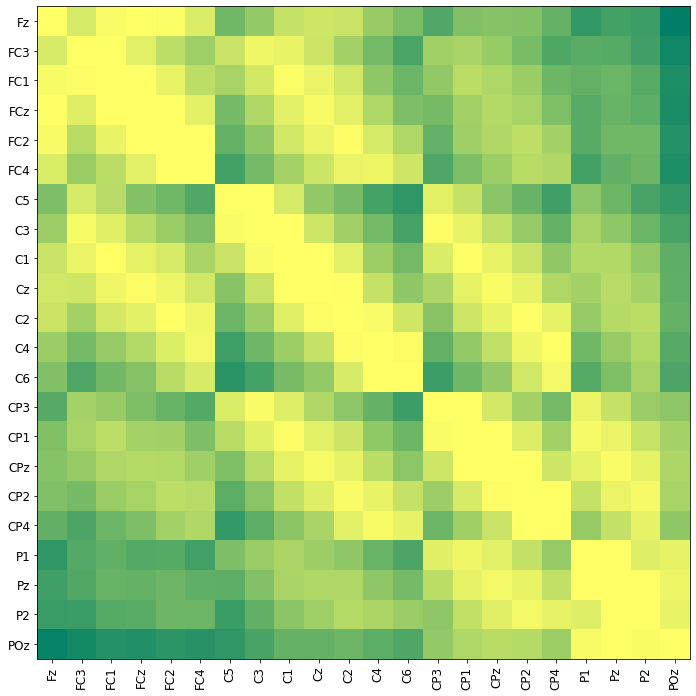

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

plot_cum_C_xx(C_xx_raw_sbjs.copy(), eeg_ch_names, axs, cmap='summer', fontsize=12)
plt.savefig(results_dir + 'sl/' + mode  + '/none_none_C_xx.pdf', format='pdf', bbox_inches='tight')

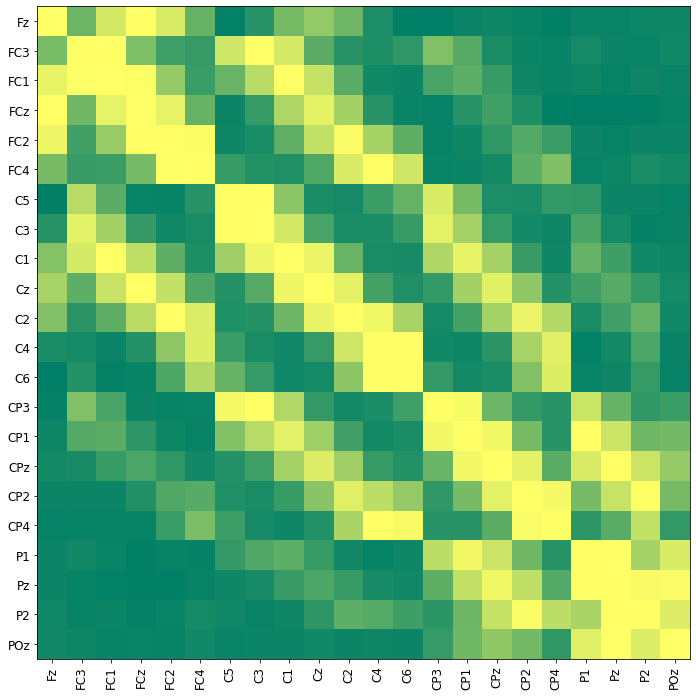

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

plot_cum_C_xx(C_xx_ica_sl_sbjs.copy(), eeg_ch_names, axs, cmap='summer', fontsize=12)
plt.savefig(results_dir + 'sl/' + mode  + '/ica_sl_C_xx.pdf', format='pdf', bbox_inches='tight')

In [ ]:
idx_ch = eeg_ch_names.index('Cz')
C_xx_raw_ch = C_xx_raw_sbjs[idx_ch,:].copy()
C_xx_raw_ch = min_max_normalization(C_xx_raw_ch, axis=None)
C_xx_raw_ch[idx_ch] = 1

C_xx_ica_sl_ch = C_xx_ica_sl_sbjs[idx_ch,:].copy()
C_xx_ica_sl_ch = min_max_normalization(C_xx_ica_sl_ch, axis=None)
C_xx_ica_sl_ch[idx_ch] = 1

In [ ]:
pos = _find_topomap_coords(info, picks=None)
pos = pos[:, :2]
pos_x, pos_y = pos.T

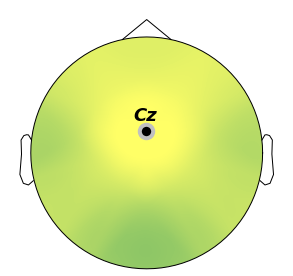

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(C_xx_raw_ch, pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
axs.scatter(pos[idx_ch,0], pos[idx_ch,1], s=180, color='k', edgecolors='silver', linewidths=4)
axs.annotate(eeg_ch_names[idx_ch], xy=pos[idx_ch,:], xytext=(0,10), textcoords="offset points", fontsize=18, fontstyle='italic', fontweight='bold', ha='center')
plt.savefig(results_dir + 'sl/' + mode  + '/none_none_C_xx_Cz.pdf', format='pdf', bbox_inches='tight')

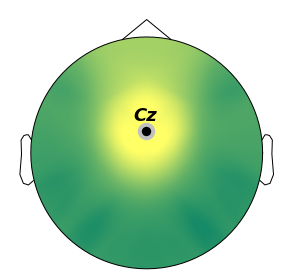

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(C_xx_ica_sl_ch, pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
axs.scatter(pos[idx_ch,0], pos[idx_ch,1], s=180, color='k', edgecolors='silver', linewidths=4)
axs.annotate(eeg_ch_names[idx_ch], xy=pos[idx_ch,:], xytext=(0,10), textcoords="offset points", fontsize=18, fontstyle='italic', fontweight='bold', ha='center')
plt.savefig(results_dir + 'sl/' + mode  + '/ica_sl_C_xx_Cz.pdf',format='pdf', bbox_inches='tight')

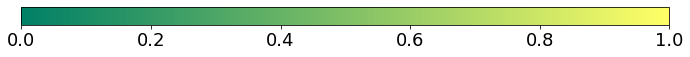

In [ ]:
fig = plt.figure(figsize=(9,0.25))
ax = fig.add_axes([0,0,1,1])
cmap = 'summer'
norm = mlp.colors.Normalize(vmin=0, vmax=1) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([]) 
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(18)
plt.savefig(results_dir + '/hbar.pdf', format='pdf', bbox_inches='tight')

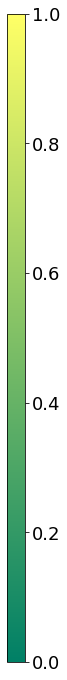

In [ ]:
fig = plt.figure(figsize=(0.25, 9))
ax = fig.add_axes([0,0,1,1])
cmap = 'summer'
norm = mlp.colors.Normalize(vmin=0, vmax=1) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([]) 
cbar = fig.colorbar(sm, cax=ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(18)
plt.savefig(results_dir + '/vbar.pdf', format='pdf', bbox_inches='tight')

## Metrics

In [ ]:
connectivities = ['plv', 'coh', 'pearson', 'motif', 'gfc']
metrics = ['acc', 'kappa', 'auc']
round = [1,2,2]

results = {} #{'C_xx':{'metric':{'Raw':, 'ICA+SL', 'prposed'}}}
comparison_results_all_sbjs = [] #array \in {{NONE, ICA+SL, proposed}, sbjs by C_xx, {ACC, kappa, AUC}}
for t_con in connectivities:
  score = np.load(results_dir + 'evaluation/' + t_con + '.npy')
  score_tuning_preprocessing = read_CV_test_results(evaluation_results_dir = results_dir + 'evaluation/' + t_con + '.npy', cross_val_results_dir= results_dir + 'hyparam_tuning/' + t_con)
  comparison_results = np.stack([score[:, :, 0].T, score[:, :, -1].T, score_tuning_preprocessing], axis=0)
  comparison_results_all_sbjs.append(comparison_results)
  mean = comparison_results.mean(axis=1)
  std = comparison_results.std(axis=1)
  mean[:,0], std[:,0] = np.round(mean[:,0]*100, round[0]), np.round(std[:,0]*100, round[0])
  mean[:,1], std[:,1] = np.round(mean[:,1], round[1]), np.round(std[:,1], round[1])
  mean[:,2], std[:,2] = np.round(mean[:,2], round[2]), np.round(std[:,2], round[2])
  results[t_con] = {metrics[0]:{'Raw':[mean[0,0], std[0,0]], 'SL+ICA':[mean[1,0], std[1,0]], 'proposed':[mean[2,0], std[2,0]]},
  metrics[1]:{'Raw':[mean[0,1], std[0,1]], 'SL+ICA':[mean[1,1], std[1,1]], 'proposed':[mean[2,1], std[2,1]]},
  metrics[2]:{'Raw':[mean[0,2], std[0,2]], 'SL+ICA':[mean[1,2], std[1,2]], 'proposed':[mean[2,2], std[2,2]]}}

comparison_results_all_sbjs = np.concatenate(comparison_results_all_sbjs, axis=1)
mean = comparison_results_all_sbjs.mean(axis=1)
std = comparison_results_all_sbjs.std(axis=1)
mean[:,0], std[:,0] = np.round(mean[:,0]*100, round[0]), np.round(std[:,0]*100, round[0])
mean[:,1], std[:,1] = np.round(mean[:,1], round[1]), np.round(std[:,1], round[1])
mean[:,2], std[:,2] = np.round(mean[:,2], round[2]), np.round(std[:,2], round[2])
results['global_results'] = {metrics[0]:{'Raw':[mean[0,0], std[0,0]], 'SL+ICA':[mean[1,0], std[1,0]], 'proposed':[mean[2,0], std[2,0]]},
metrics[1]:{'Raw':[mean[0,1], std[0,1]], 'SL+ICA':[mean[1,1], std[1,1]], 'proposed':[mean[2,1], std[2,1]]},
metrics[2]:{'Raw':[mean[0,2], std[0,2]], 'SL+ICA':[mean[1,2], std[1,2]], 'proposed':[mean[2,2], std[2,2]]}}

with open(results_dir + 'mean_by_sbjs_results.txt', 'wb') as f:
      pdump(results, f)

with open(results_dir + 'sbjs_results.txt', 'wb') as f:
      pdump(comparison_results_all_sbjs, f)

## Preprocessing Steps

In [ ]:
metric = 'acc'

score = read_CV_results(subjects, results_dir + 'hyparam_tuning/' + type_con + '/', 'mean_test_'+metric)

idx_best_params = np.argmax(score, axis=1)
params = ['none_none', 'none_sl', 'ica_none', 'ica_sl']
best_params = []
for idx_bp in idx_best_params:
  best_params.append(params[idx_bp])
best_params = np.asarray(best_params)

sbjs_prep_steps_perc = np.zeros(len(params))
for i in range(len(params)):
  sbjs_prep_steps_perc[i] = np.round(100*np.sum(best_params == params[i])/subjects.shape[0],2)

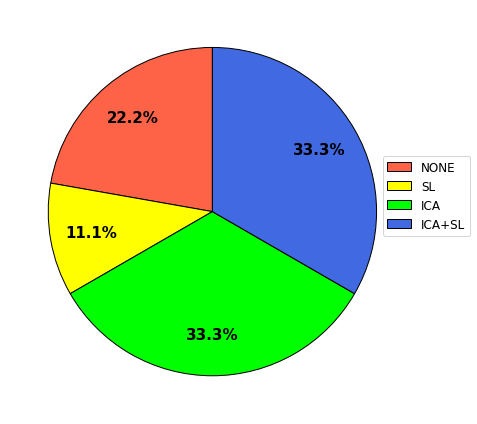

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
axs.pie(sbjs_prep_steps_perc, colors = ['tomato', 'yellow', 'lime', 'royalblue'], autopct='%1.1f%%', startangle=90, pctdistance=0.75, wedgeprops={'edgecolor':'k', 'linewidth': 1},
        textprops={'color':'k', 'weight':'bold', 'fontsize':15})
axs.legend(bbox_to_anchor=(0.9, 0.65), labels=['NONE', 'SL', 'ICA', 'ICA+SL'], fontsize=12)
fig.tight_layout()
plt.savefig(results_dir + 'Thesis/' + 'percentage_preprocessing_hyparams_sbs.pdf', format='pdf', bbox_inches='tight')

## Noise structure vs Hyparams vs ACC

In [ ]:
score = np.load(results_dir + 'evaluation/' + type_con + '.npy')
score_tuning_preprocessing = read_CV_test_results(evaluation_results_dir = results_dir + 'evaluation/' + type_con + '.npy', cross_val_results_dir = results_dir + 'hyparam_tuning/' + type_con)
comparison_results = np.stack([score[:, :, 0].T, score[:, :, -1].T, score_tuning_preprocessing], axis=0) # {{NONE, ICA+SL, proposed}, sbjs, {ACC, kappa, AUC}}
comparison_results[:,:,0] = np.round(100*comparison_results[:,:,0], 1)
comparison_results[:,:,1:] = np.round(comparison_results[:,:,1:], 2)

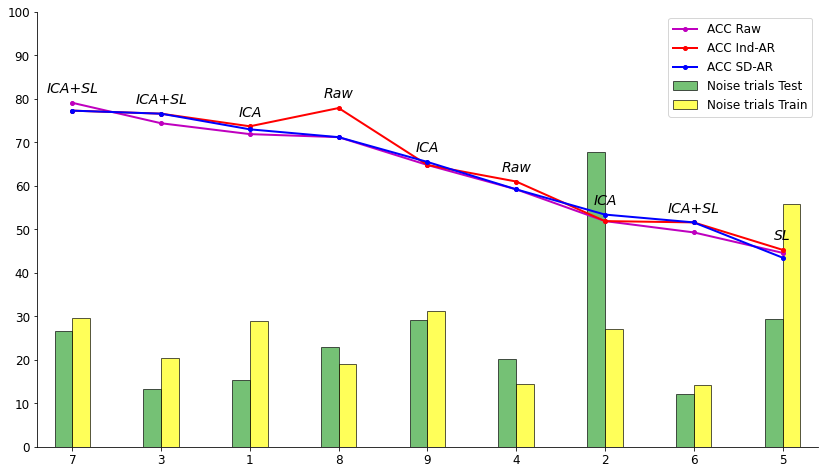

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14,8))

noise_trials_ratio_train = ica_noise_trials_ratio(subjects, results_dir + 'ica/training/')
noise_trials_ratio_eval = ica_noise_trials_ratio(subjects, results_dir + 'ica/evaluation/')
idx_ord_sbjs = np.argsort(comparison_results[0, :, 0])[::-1] #subjects descendetnt order based in acc of Raw

axs.bar(np.arange(subjects.shape[0])-0.1, noise_trials_ratio_eval[idx_ord_sbjs], width=0.2, color='tab:green', alpha=0.65, edgecolor='k', linewidth=1, label='Noise trials Test')
axs.bar(np.arange(subjects.shape[0])+0.1, noise_trials_ratio_train[idx_ord_sbjs], width=0.2, color='yellow', alpha=0.65,  edgecolor='k', linewidth=1, label='Noise trials Train')
axs.plot(np.arange(subjects.shape[0]), comparison_results[0, idx_ord_sbjs, 0], 'o-', color='m', markersize=4, linewidth=2, label='ACC Raw')
axs.plot(np.arange(subjects.shape[0]), comparison_results[1, idx_ord_sbjs, 0], 'o-', color='r', markersize=4, linewidth=2, label='ACC Ind-AR')
axs.plot(np.arange(subjects.shape[0]), comparison_results[-1, idx_ord_sbjs, 0], 'o-', color='b', markersize=4, linewidth=2, label='ACC SD-AR')

for x,y in zip(np.arange(subjects.shape[0]), comparison_results[:, idx_ord_sbjs, 0].T):
  if best_params[idx_ord_sbjs[x]] == 'none_none':
    label = 'Raw'
  elif best_params[idx_ord_sbjs[x]] == 'none_sl':
    label = 'SL'
  elif best_params[idx_ord_sbjs[x]] == 'ica_none':
    label = 'ICA'
  else:
    label = 'ICA+SL'

  plt.annotate(label, (x,np.max(y)), textcoords="offset points", xytext=(0,10), ha='center',fontstyle = 'italic', fontsize=14)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_ylim([0, 100])
axs.set_xlim([-0.4, subjects.shape[0]-0.6])
axs.set_yticks(np.linspace(0, 100, 11, dtype=np.uint16))
axs.set_yticklabels(np.linspace(0, 100, 11, dtype=np.uint16), fontsize=12)
axs.set_xticks(np.arange(subjects.shape[0]))
axs.set_xticklabels(subjects[idx_ord_sbjs], fontsize=12)
plt.legend(loc=1, fontsize=12)
#axs.set_ylabel('(%)', fontfamily='serif', fontsize=22, weight=500)
#axs.set_xlabel('Subjects', fontfamily='serif', fontsize=22, weight=500)
plt.savefig(results_dir + 'Thesis/' + 'porcentage_noise_trials_sbjs_acc.pdf',format='pdf', bbox_inches='tight')

## Topographical maps

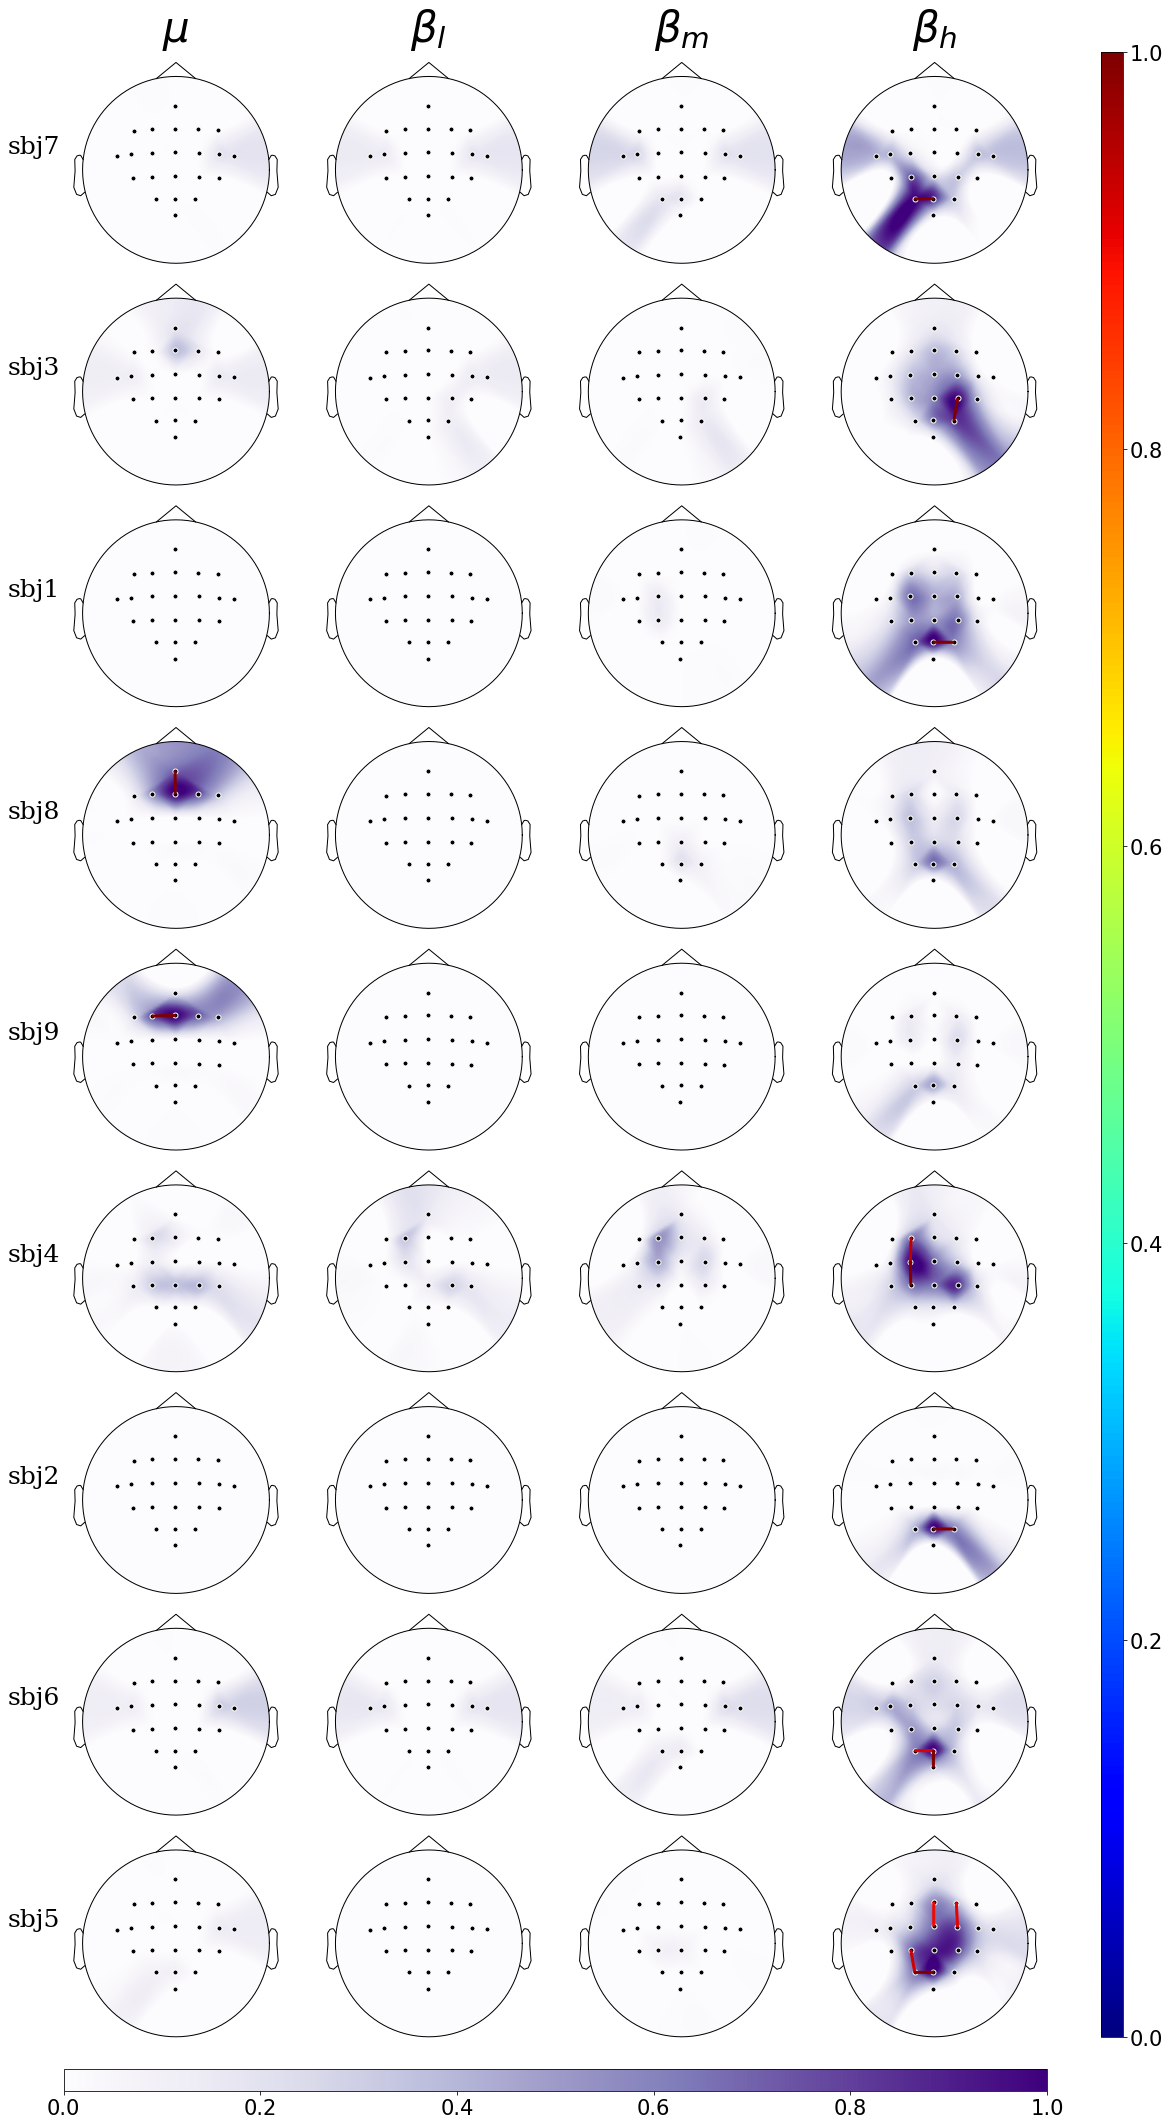

In [ ]:
fb_label = [r'$\mu$', r'$\beta_{l}$', r'$\beta_{m}$', r'$\beta_{h}$']
n_f_bank = len(fb_label)
w_label = ['sbj'+str(sbj) for sbj in subjects[idx_ord_sbjs]]

coef = read_CV_models(subjects[idx_ord_sbjs], results_dir + 'models/' + type_con + '/', best_params[idx_ord_sbjs])
coef = np.abs(coef)
coef = min_max_normalization(coef, axis=-1)
coef = np.max(coef, axis=1)
coef[coef < 0.2] = 0
coef = np.reshape(coef, (db.metadata['subjects'], int(n_eeg_chs*(n_eeg_chs - 1)*0.5), n_f_bank))
coef = np.swapaxes(coef, 0, 1)
coef = coef.reshape(-1)
pbc.plot_connectivities(coef.copy(), info, eeg_ch_names, n_vwt=db.metadata['subjects'], n_f_bank=n_f_bank, min_max_normalization_type='windows', thr=0.9,
                        w_label=w_label, fb_label=fb_label, labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':25, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':21},
                        relevant_channels=False, plot_channels_names=False, figsize=(15,30), cmap_connectivities='jet', cmap_tplt='Purples',
                        save=True, path=results_dir + 'Thesis/' + 'Cxx_topoplos_sbs', format='pdf')